In [1]:
import random
import numpy as np
import tensorflow as tf
import os, re, time, math, warnings
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


from tensorflow.keras import layers
from tensorflow.python.framework import ops
from tensorflow.keras.regularizers import l2

from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.model_selection import GridSearchCV
from pathlib import Path
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

DATA_PATH = Path(r'C:\Users\timot\PycharmProjects\CHEM_V_507\Midterm_Problems\KRR\H3O+ (1).csv')
CSV_IN   = DATA_PATH / "H3O+ (1).csv"        # 6-D features + target
CSV_OUT  = DATA_PATH / "krr_H3Oplus_benchmark.csv"
RANDOM_SEED = 3


C:\Users\timot\.conda\envs\CHEM_V_507A\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


The function below is defined to represent two sets of data (x,y, by a solid cuve) and (xs,ys, by symbols) for graphical model illustration

In [2]:
def plot_model_results(x, y, color,xs,ys,xlabel):
  plt.scatter(xs, ys, marker='.',color=color)
  plt.plot(x, y, color='darkblue')
  plt.xlabel(xlabel,size=18)
  plt.ylabel('$y$',size=18)
  plt.tight_layout()
#  plt.legend()

The code below generates our data

In [3]:
x_original = []
y_original = []
xtransformed = []
step = 0.08
xvariable =  0
while (xvariable<9):
    xvariable = xvariable + step
    transformed_variable = xvariable*math.sin(xvariable) + random.gauss(0,0.3)
    backtransformed_variable = xvariable*math.sin(xvariable)
    x_original.append(xvariable)
    y_original.append(transformed_variable)
    xtransformed.append(backtransformed_variable)
    
train_features = x_original # <-- features or inputs (only one in this case)
train_labels = y_original   # <-- label or output (also only one in this case)
# the following normalizes the input variable:
x_feature = np.array(train_features)
x_feature_normalizer = tf.keras.layers.Normalization(input_shape=(1,))  # input_shape = [1,] means 1 input
x_feature_normalizer.adapt(x_feature)    # <-- this computes the mean and variance of the data
#                                                 and stores them in as the layer's weights    


C:\Users\timot\.conda\envs\CHEM_V_507A\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


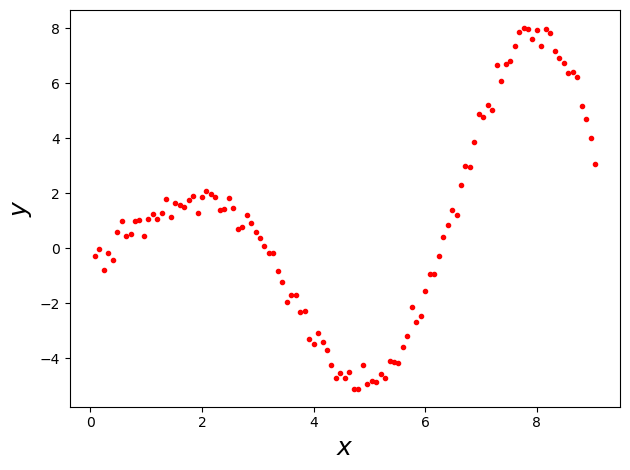

In [4]:
def simple_plot(x, y, color,xlabel):
  plt.scatter(x, y, marker='.',color=color)
  plt.xlabel(xlabel,size=18)
  plt.ylabel('$y$',size=18)
  plt.tight_layout()
#  plt.legend()

file_directory_path = r'C:\Users\timot\PycharmProjects\CHEM_V_507\Midterm_Problems\KRR'
simple_plot(x_original, y_original, 'red','$x$')
plt.savefig(file_directory_path+'data-plot-1.png')
plt.show()
plt.close()

Let's first implement Kernel Ridge Regression following the equations in the notes, from scratch

I have written the code below, naming the variables to be self-expalantory - can you read it and match the code to the equations in the notes? 

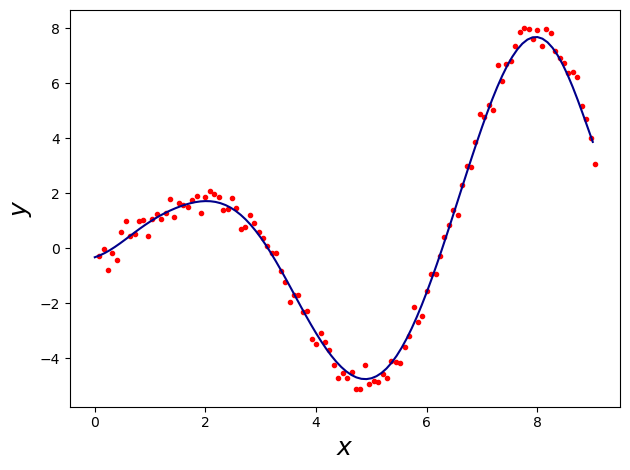

In [6]:
# Roman's implementation of KRR

regularization_parameter = 0.5 # < -- play with this parameter
alpha = regularization_parameter
rbf_kernel_length_hyperparameter = 1.   # < -- play with this parameter
gamma = rbf_kernel_length_hyperparameter
x_inputs = np.array(train_features)
y_observations = np.array(train_labels)
n = x_inputs.shape[0]   # < --- this is the number of our training points
Kernel_matrix = np.empty([n,n])
for i in range(n):
    for j in range(n):
        distance = np.absolute(x_inputs[i]- x_inputs[j])
        Kernel_matrix[i,j] = math.exp(-gamma*distance**2)
I = np.identity(n)  # < -- identity matrix of size n x n    
Matrix_to_invert = Kernel_matrix + alpha*I
Inverted_matrix = np.linalg.inv(Matrix_to_invert)
alpha_vector = np.matmul(Inverted_matrix,y_observations)  # <--- this is the vector of alphas
#
#
x_for_plotting = np.linspace(0.0, 9, 100)
predicted_y = np.empty(x_for_plotting.shape[0])
for i in range(x_for_plotting.shape[0]):
    x = x_for_plotting[i]
    k_vector = np.empty([n])
    for j in range(n): 
        distance = np.absolute(x - x_inputs[j])
        k_vector[j] = math.exp(-gamma*distance**2)
    k_transpose = np.matrix.transpose(k_vector)
    prediction = np.matmul(k_transpose,alpha_vector)
    predicted_y[i] = prediction
    
color='red'
xlabel='$x$'
plot_model_results(x_for_plotting,predicted_y,color,train_features,train_labels,xlabel)
plt.savefig(file_directory_path+"krr-1.png")
plt.show()
plt.close()

    

The following is an example of sklearn implementation of Kernel Ridge Regression

We being by defining the model (alpha is the regularizatio parameter -- same as lambda in lecture notes) with 'rbf' kernel in this case

The model is with with .fit(x_data, y_data)

Note that the x_data for a 1D problem must be reshaped as .reshape(-1,1) -- see the output of print(x_features.shape) and print(x_data.shape) tp see what this reshaping does

The prediction is done with.predict(x_data_array)

before reshaping: (113,)
after reshaping: (113, 1)
Time for KRR fitting: 0.020
Time for KRR prediction: 0.001


FileNotFoundError: [Errno 2] No such file or directory: '/Users/rkrems/Desktop/Chem507/Images/linear-regression-1.png'

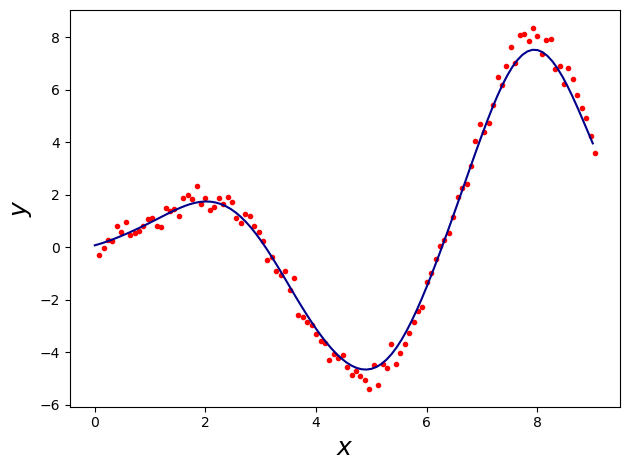

In [11]:
# This is the sklearn implementation of Kernel Ridge regression
# We will look at the tensorflow.keras implementation below

our_kernel_ridge_model = KernelRidge(alpha=1.0,kernel='rbf')
stime = time.time()
print('before reshaping:', x_feature.shape)
x_data = x_feature.reshape(-1, 1)
print('after reshaping:', x_data.shape)
our_kernel_ridge_model.fit(x_data, y_original)
print("Time for KRR fitting: %.3f" % (time.time() - stime)) 

x_for_plotting = np.linspace(0.0, 9, 100)
x_for_plotting_reshaped = x_for_plotting.reshape(-1,1)
stime = time.time()
y_from_the_model = our_kernel_ridge_model.predict(x_for_plotting_reshaped)
print("Time for KRR prediction: %.3f" % (time.time() - stime))


color='red'
xlabel='$x$'
plot_model_results(x_for_plotting,y_from_the_model,color,train_features,train_labels,xlabel)
plt.savefig(file_directory_path+"linear-regression-1.png")
plt.show()
plt.close()


The code below implements KRR with sklearn, but now with optimization of hyperparameters using grid search and cross-validation

before reshaping: (113,)
after reshaping: (113, 1)
Time for KRR fitting: 2.335
Time for KRR prediction: 0.001


FileNotFoundError: [Errno 2] No such file or directory: '/Users/rkrems/Desktop/Chem507/Images/linear-regression-1.png'

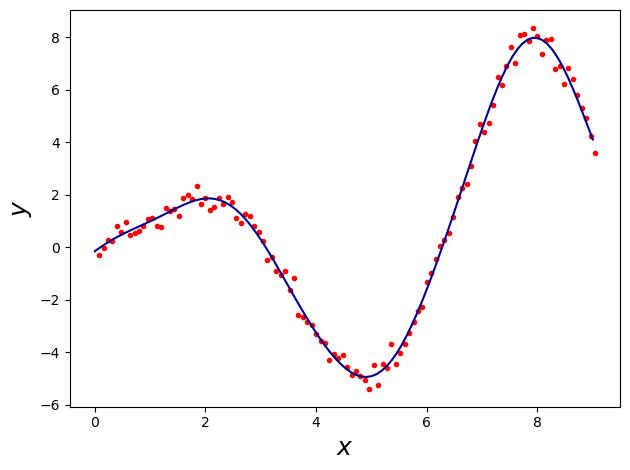

In [12]:
# This is the sklearn implementation of Kernel Ridge regression with cross-validation and grid search
# We will look at the tensorflow.keras implementation below

# Fit KernelRidge with parameter selection based on 5-fold cross validation
hyperparameter_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],
              "kernel": [ExpSineSquared(l, p)
                         for l in np.logspace(-2, 2, 10)
                         for p in np.logspace(0, 2, 10)]}
our_kernel_ridge_model = GridSearchCV(KernelRidge(), param_grid=hyperparameter_grid)
#our_kernel_ridge_model = KernelRidge(alpha=1.0,kernel='rbf')
stime = time.time()
print('before reshaping:', x_feature.shape)
x_data = x_feature.reshape(-1, 1)
print('after reshaping:', x_data.shape)
our_kernel_ridge_model.fit(x_data, y_original)
print("Time for KRR fitting: %.3f" % (time.time() - stime)) 

x_for_plotting = np.linspace(0.0, 9, 100)
x_for_plotting_reshaped = x_for_plotting.reshape(-1,1)
stime = time.time()
y_from_the_model = our_kernel_ridge_model.predict(x_for_plotting_reshaped)
print("Time for KRR prediction: %.3f" % (time.time() - stime))


color='red'
xlabel='$x$'
plot_model_results(x_for_plotting,y_from_the_model,color,train_features,train_labels,xlabel)
plt.savefig(file_directory_path+"linear-regression-1.png")
plt.show()
plt.close()


Sklearn has a function fo simple Ridge regression (as opposed to Kernel Ridge).

Let's see what happens if we do Ridge, as below

Time for Ridge fitting: 0.003
Time for Ridge prediction: 0.000


FileNotFoundError: [Errno 2] No such file or directory: '/Users/rkrems/Desktop/Chem507/Images/krr-3.png'

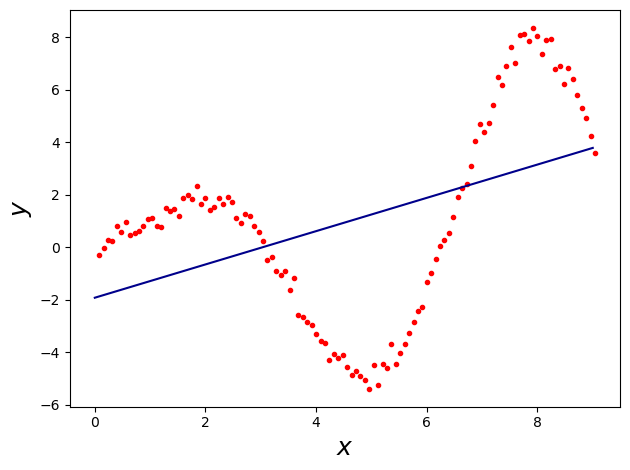

In [13]:
# Let's compare the above result with simple ridge regression

ridge_model = Ridge()
stime = time.time()
x_data = x_feature.reshape(-1, 1)
ridge_model.fit(x_data, y_original)
print("Time for Ridge fitting: %.3f" % (time.time() - stime)) 

x_for_plotting = np.linspace(0.0, 9, 100)
x_for_plotting_reshaped = x_for_plotting.reshape(-1,1)
stime = time.time()
y_from_the_model = ridge_model.predict(x_for_plotting_reshaped)
print("Time for Ridge prediction: %.3f" % (time.time() - stime))


color='red'
xlabel='$x$'
plot_model_results(x_for_plotting,y_from_the_model,color,train_features,train_labels,xlabel)
plt.savefig(file_directory_path+"krr-3.png")
plt.show()
plt.close()


Can we try to build a nonlinear fit with a NN? 

Is everything below self-explanatory? 

Note the use of kernel_regularizer = l2 <--- this effectively makes the function below the same as Kernel Ridge Regression

In [14]:
# Remember this NN?
# The following builds the model 
our_linear_model = tf.keras.Sequential([
    x_feature_normalizer,               # <-- this normalizes the input
    layers.Dense(units=30,activation='sigmoid',kernel_regularizer=l2(0.00001)),
    layers.Dense(units=1),               # <-- units = 1 means this produces one output
])
our_linear_model.summary()
our_linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')         # <-- configure the model

results = our_linear_model.fit(
    train_features, train_labels,       # <-- inputs, outputs
    epochs=100,
    # suppress logging
    verbose=0)                          # <-- build the model


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 1)              │           227 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 318 (1.25 KB)

 Trainable params: 91 (364.00 B)

 Non-trainable params: 227 (912.00 B)

ValueError: Unrecognized data type: x=[0.08, 0.16, 0.24, 0.32, 0.4, 0.48000000000000004, 0.56, 0.64, 0.72, 0.7999999999999999, 0.8799999999999999, 0.9599999999999999, 1.0399999999999998, 1.1199999999999999, 1.2, 1.28, 1.36, 1.4400000000000002, 1.5200000000000002, 1.6000000000000003, 1.6800000000000004, 1.7600000000000005, 1.8400000000000005, 1.9200000000000006, 2.0000000000000004, 2.0800000000000005, 2.1600000000000006, 2.2400000000000007, 2.3200000000000007, 2.400000000000001, 2.480000000000001, 2.560000000000001, 2.640000000000001, 2.720000000000001, 2.800000000000001, 2.8800000000000012, 2.9600000000000013, 3.0400000000000014, 3.1200000000000014, 3.2000000000000015, 3.2800000000000016, 3.3600000000000017, 3.4400000000000017, 3.520000000000002, 3.600000000000002, 3.680000000000002, 3.760000000000002, 3.840000000000002, 3.920000000000002, 4.000000000000002, 4.080000000000002, 4.160000000000002, 4.240000000000002, 4.320000000000002, 4.400000000000002, 4.480000000000002, 4.560000000000002, 4.640000000000002, 4.720000000000002, 4.8000000000000025, 4.880000000000003, 4.960000000000003, 5.040000000000003, 5.120000000000003, 5.200000000000003, 5.280000000000003, 5.360000000000003, 5.440000000000003, 5.520000000000003, 5.600000000000003, 5.680000000000003, 5.760000000000003, 5.840000000000003, 5.9200000000000035, 6.0000000000000036, 6.080000000000004, 6.160000000000004, 6.240000000000004, 6.320000000000004, 6.400000000000004, 6.480000000000004, 6.560000000000004, 6.640000000000004, 6.720000000000004, 6.800000000000004, 6.880000000000004, 6.960000000000004, 7.0400000000000045, 7.1200000000000045, 7.200000000000005, 7.280000000000005, 7.360000000000005, 7.440000000000005, 7.520000000000005, 7.600000000000005, 7.680000000000005, 7.760000000000005, 7.840000000000005, 7.920000000000005, 8.000000000000005, 8.080000000000005, 8.160000000000005, 8.240000000000006, 8.320000000000006, 8.400000000000006, 8.480000000000006, 8.560000000000006, 8.640000000000006, 8.720000000000006, 8.800000000000006, 8.880000000000006, 8.960000000000006, 9.040000000000006] (of type <class 'list'>)

In [10]:
x_for_plotting = tf.linspace(0.0, 9, 100)
y_from_the_model = our_linear_model.predict(x_for_plotting)

color='red'
xlabel='$x$'
plot_model_results(x_for_plotting,y_from_the_model,color,train_features,train_labels,xlabel)
plt.savefig(file_directory_path+"linear-regression-1.png")
plt.show()
plt.close()

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (32, 113)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32,), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>